# This script performs the analysis in the supplemental materials including:
### Pred-prey trajectories with symmetric vs. asymmetric interaction strength, pred-prey abundances across predator harvest, and sensitivity analysis

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Pred - Prey Model Functions

In [11]:
def dNdt(H, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    
    return dH, dP

In [12]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, parameters_dict):
    H_init = H
    P_init = P 
    
    dH1, dP1 = dNdt(H,P,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    
    dH2, dP2 = dNdt(H1,P1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, herbivore_harvest, predator_harvest

In [13]:
# Function to run the model 

def run_model(INIT_H, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, H_harvest_array, P_harvest_array

## Supplemental Fig 1 - Interaction Strength Trajectories

### Define a function to set to normal params

In [14]:
def default_params():
    numyears = 100
    #Herbivore parameters:
    r_H = 0.4 # growth rate of herbivores
    K_H = 5000 # carrying capacity of herbivores
    theta_H = 50 # immigration of herbivores
    c = 0.4 #additional mortality of H 
    d = 500 # value of H when predation half its max value 
    q_H = 1. # proportionality constant for herbivore harvest 
    E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
    #Predator parameters:
    r_P = 0.2 # growth rate of predator 
    K_P = 2000 # carrying capactiy of predators
    b = 0.4 # additional growth of P due to H
    theta_P = 10 # immigration of predators 
    q_P = 1. # proportionality constant for predator harvest 
    E_P = 0.0 # Effort for predator harvest

    parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

    return parameters_dict

In [15]:
#Run model simulation; set params to default
parameters_dict = default_params()

numyears = 100
H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

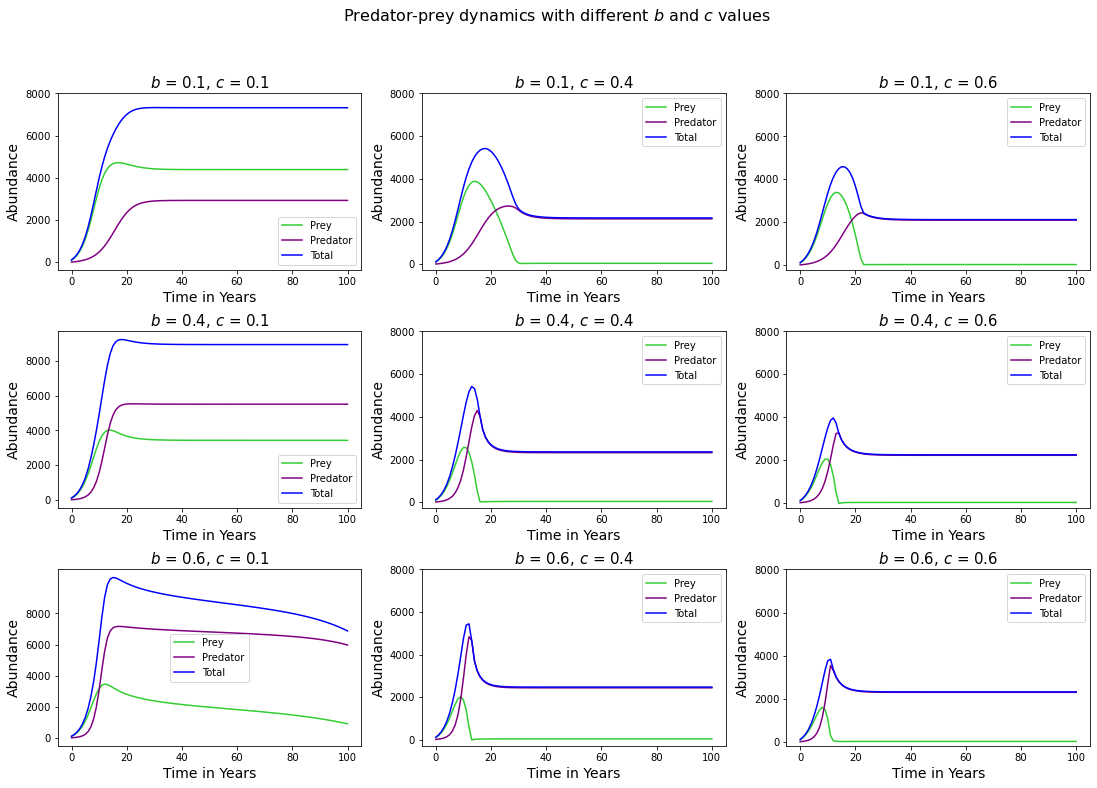

In [16]:
# Define interaction strengths
b_values = [0.1, 0.4, 0.6]
c_values = [0.1, 0.4, 0.6]
my_yticks = [0, 2000, 4000, 6000, 8000]

# To store results
results = {}

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        T_array = H_array + P_array  # Total abundance
        
        # Store the results in a dictionary
        results[(i, j)] = {
            'H_array': H_array,
            'P_array': P_array,
            'T_array': T_array
        }

# Plot trajectories
fig, axs = plt.subplots(3, 3, figsize=(18.5, 12))

for i in range(3):
    for j in range(3):
        H_array = results[(i, j)]['H_array']
        P_array = results[(i, j)]['P_array']
        T_array = results[(i, j)]['T_array']
        
        axs[i, j].plot(range(numyears + 1), H_array, label='Prey', color="limegreen")
        axs[i, j].plot(range(numyears + 1), P_array, label='Predator', color="purple")
        axs[i, j].plot(range(numyears + 1), T_array, label='Total', color="blue")
        axs[i, j].set_title(f'$b$ = {b_values[i]}, $c$ = {c_values[j]}', fontsize=15)
        axs[i, j].set_yticks(my_yticks)
        axs[i, j].set_xlabel('Time in Years', fontsize=14)
        axs[i, j].set_ylabel('Abundance', fontsize=14)
        axs[i, j].legend()

# Add a common title to the figure
fig.suptitle('Predator-prey dynamics with different $b$ and $c$ values', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

plt.savefig("manuscript_figs/time_series_abundance_total.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Supplemental Fig 2 - Predator Fishing

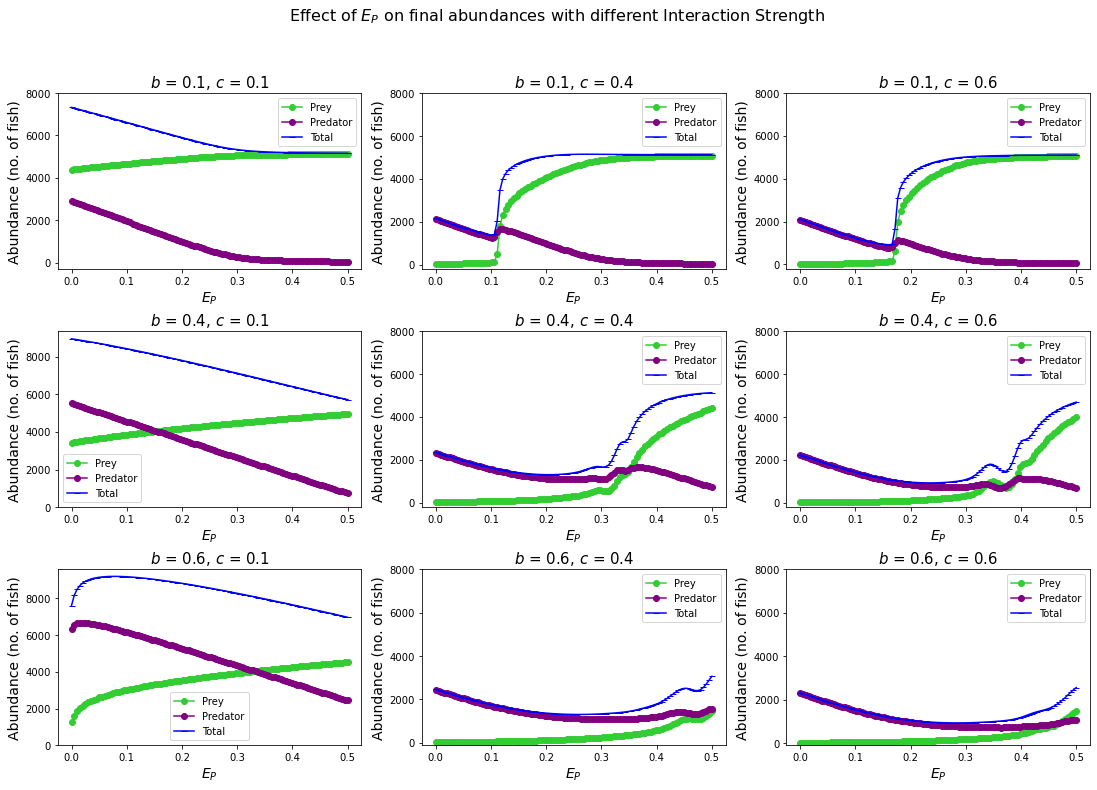

In [17]:
size = 100
E_P_array = np.linspace(0, 0.5, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)
b_values = [0.1, 0.4, 0.6]
c_values = [0.1, 0.4, 0.6]

# Y-axes Values 
my_yticks = [0, 2000, 4000, 6000, 8000]

#Set default params:
numyears = 100
parameters_dict = default_params()

#Initial conditions:
H0 = 100 
P0 = 10

# To store results
results = {}

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        # Store the final abundances for different E_P values
        H_final_array = np.zeros(len(E_P_array))
        P_final_array = np.zeros(len(E_P_array))
        H_harvest_final_array = np.zeros(len(E_P_array))
        P_harvest_final_array = np.zeros(len(E_P_array))
        
        for k, E_P in enumerate(E_P_array):
            parameters_dict['b'] = b
            parameters_dict['c'] = c
            parameters_dict['E_P'] = E_P
            
            H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
            
            # Calculate final values as the mean of the last 25 years
            H_final_array[k] = np.mean(H_array[-25:])
            P_final_array[k] = np.mean(P_array[-25:])
            H_harvest_final_array[k] = np.mean(H_harvest_array[-25:])
            P_harvest_final_array[k] = np.mean(P_harvest_array[-25:])
        
        # Store results
        results[(i, j)] = {
            'H_final_array': H_final_array,
            'P_final_array': P_final_array,
            'H_harvest_final_array': H_harvest_final_array,
            'P_harvest_final_array': P_harvest_final_array,
            'T_final_array': H_final_array + P_final_array  # Total abundance
        }

# Plot average of last 25 years of trajectories
fig, axs = plt.subplots(3, 3, figsize=(18.5, 12))

for i in range(3):
    for j in range(3):
        data = results[(i, j)]
        H_final_array = data['H_final_array']
        P_final_array = data['P_final_array']
        T_final_array = data['T_final_array']
        
        axs[i, j].plot(E_P_array, H_final_array, color="limegreen", marker='o', label='Prey')
        axs[i, j].plot(E_P_array, P_final_array, color="purple", marker='o', label='Predator')
        axs[i, j].plot(E_P_array, T_final_array, color="blue", marker='_', label='Total')
        axs[i, j].set_title(f'$b$ = {b_values[i]}, $c$ = {c_values[j]}', fontsize=15)
        axs[i, j].set_xlabel('$E_P$', fontsize=14)
        axs[i, j].set_ylabel('Abundance (no. of fish)', fontsize=14)
        axs[i, j].set_yticks(my_yticks)
        axs[i, j].legend()

# Add a common title to the figure
fig.suptitle('Effect of $E_P$ on final abundances with different Interaction Strength', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

plt.savefig("manuscript_figs/pred_fishing.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Supplemental Fig 3 - Sensitivity Analysis

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


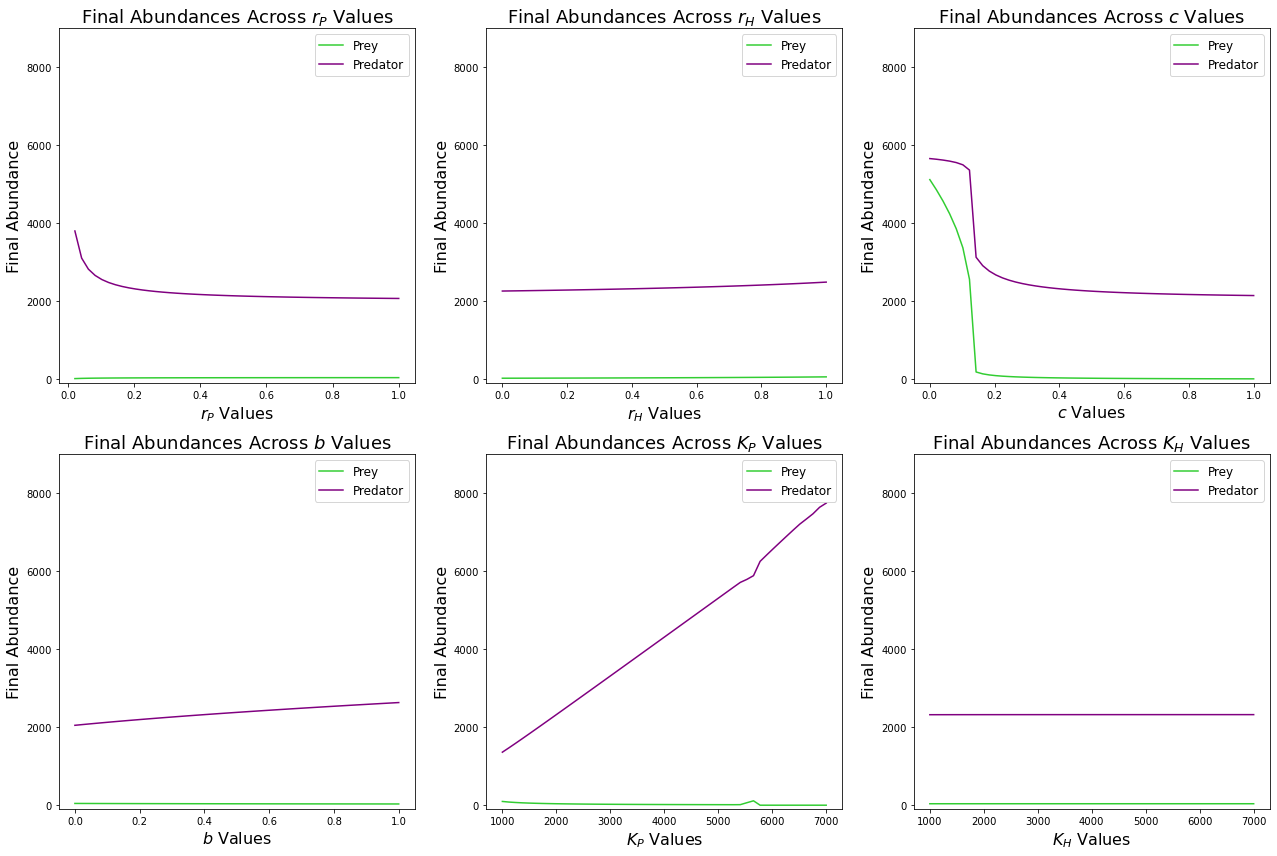

In [18]:
# Size of the parameter arrays
size = 50

# Parameter ranges to plot
param_ranges = {
    'r_P': np.linspace(0.0, 1.0, size),
    'r_H': np.linspace(0.0, 1.0, size),
    'c': np.linspace(0.0, 1.0, size),
    'b': np.linspace(0.0, 1.0, size),
    'K_P': np.linspace(1000, 7000, size),
    'K_H': np.linspace(1000, 7000, size)
}

# Storage for final abundances
final_abundances = {
    'r_P': (np.zeros(size), np.zeros(size)),
    'r_H': (np.zeros(size), np.zeros(size)),
    'c': (np.zeros(size), np.zeros(size)),
    'b': (np.zeros(size), np.zeros(size)),
    'K_P': (np.zeros(size), np.zeros(size)),
    'K_H': (np.zeros(size), np.zeros(size))
}

# Compute final abundances for each parameter range
for param, values in param_ranges.items():
    H_final, P_final = np.zeros(size), np.zeros(size)
    for i, value in enumerate(values):
        params = default_params()
        params[param] = value
        
        # Run model
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, params)
        
        # Final abundances as the mean of the last 25 time steps
        H_final[i] = np.mean(H_array[-25:])
        P_final[i] = np.mean(P_array[-25:])
        
        # Any negative values to zero
        H_final[i] = max(H_final[i], 0)
        P_final[i] = max(P_final[i], 0)
    
    # Store the results
    final_abundances[param] = (H_final, P_final)

# Plot results
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Titles and labels for each subplot
titles = [
    'Final Abundances Across $r_P$ Values',
    'Final Abundances Across $r_H$ Values',
    'Final Abundances Across $c$ Values',
    'Final Abundances Across $b$ Values',
    'Final Abundances Across $K_P$ Values',
    'Final Abundances Across $K_H$ Values'
]

x_labels = [
    '$r_P$ Values',
    '$r_H$ Values',
    '$c$ Values',
    '$b$ Values',
    '$K_P$ Values',
    '$K_H$ Values'
]

y_labels = 'Final Abundance'

# Plot for each parameter
for idx, (param, (H_final, P_final)) in enumerate(final_abundances.items()):
    row = idx // 3
    col = idx % 3
    
    axs[row, col].plot(param_ranges[param], H_final, label='Prey', color="limegreen")
    axs[row, col].plot(param_ranges[param], P_final, label='Predator', color="purple")
    axs[row, col].set_title(titles[idx], fontsize=18)
    axs[row, col].set_xlabel(x_labels[idx], fontsize=16)
    axs[row, col].set_ylabel(y_labels, fontsize=16)
    axs[row, col].set_ylim(-100, 9000)
    axs[row, col].legend(fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.savefig("manuscript_figs/sensitivity.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()